In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from json import load
import regex as re
from pathlib import Path
from importlib import reload
from pprint import pp
from collections import Counter

In [4]:
import utils as u

In [96]:
# Call to reload an imported module if it has been updated
reload(u)

<module 'utils' from '/home/ruskirin/Documents/Course Material/Assignments/m450/reddit-assortativity-analysis/utils.py'>

In [5]:
%matplotlib notebook
plt.rcParams.update({'axes.titlesize': 'large'})

In [6]:
data_path = Path('data/chain_networks')
data_path.exists()

True

In [7]:
subreds_raw = dict()

In [8]:
# All the subreddits and their paths
subreddits_paths = [sr for sr in data_path.iterdir()]
subreddits = [sr.stem for sr in data_path.iterdir()]
sorted(subreddits)

['2007scape',
 '240sx',
 '24hoursupport',
 '3DS',
 '3Dprinting',
 '3amjokes',
 '3dsFCswap',
 '49ers',
 '4chan',
 '4x4',
 '90daysgoal',
 '911truth',
 'ABDL',
 'ABraThatFits',
 'ACMilan',
 'ACTrade',
 'ADHD',
 'AFL',
 'AMA',
 'ANormalDayInRussia',
 'AbandonedPorn',
 'Accounting',
 'ActionFigures',
 'Adelaide',
 'AdoptMyVillager',
 'Advice',
 'AdviceAnimals',
 'AfterEffects',
 'AirForce',
 'Albany',
 'Albuquerque',
 'Aleague',
 'AlienBlue',
 'AllThingsTerran',
 'AmIFreeToGo',
 'AmISexy',
 'Amateur',
 'AmateurArchives',
 'AmericanHorrorStory',
 'Amsterdam',
 'Anarchism',
 'Anarcho_Capitalism',
 'Anarchy101',
 'Android',
 'AndroidGaming',
 'AndroidQuestions',
 'AnimalCrossing',
 'AnimalsBeingBros',
 'AnimalsBeingJerks',
 'AnimeFigures',
 'AnimeSketch',
 'Animesuggest',
 'AnnArbor',
 'AntiJokes',
 'Anticonsumption',
 'Anxiety',
 'AnythingGoesNews',
 'AppHookup',
 'AppalachianTrail',
 'Aquariums',
 'ArcherFX',
 'Archery',
 'Argentinacirclejerk',
 'Art',
 'ArtisanVideos',
 'ArtistLounge',
 'As

#### Non-political Subreddits by Group:
Analysis of political subreddits must be compared to other groups in order to observe any trends. Ideally I would find a group of subreddits that are as closely resembling of natural social groups as possible, so as to perhaps show that advice-giving subreddits or those dealing with sensitive topics (eg. politics, sports) show great homophilic tendincies or high betweenness. This would support the hypothesis that reddit is not a great place to turn to for advice or gaining perspective, as the communities that purport to do that are biased.

The groups chosen to be sampled are those related to: 
<ul>
    <li>gaming: 
        <ul>
            <li>CrusaderKings</li>
            <li>Diablo</li>
            <li>GTAV</li>
            <li>2007scape</li>
            <li>HalfLife</li>
        </ul>
    </li>
    <li>geographical(dedicated to specific cities/countries): 
        <ul>
            <li>Amsterdam</li>
            <li>Brooklyn</li>
            <li>Hawaii</li>
            <li>Israel</li>
            <li>LosAngeles</li>
        </ul>
    </li>
    <li>medicine(dedicated to certain mental or physical conditions): 
        <ul>
            <li>ChronicPain</li>
            <li>Fibromyalgia</li>
            <li>alcoholism</li>
            <li>bipolar</li>
            <li>socialanxiety</li>
        </ul>
    </li>
    <li>sports: 
        <ul>
            <li>Bowling</li>
            <li>Kayaking</li>
            <li>nyjets</li>
            <li>powerlifting</li>
            <li>lacrosse</li>
        </ul>
    </li>
    <li>religion: 
        <ul>
            <li>Catholicism</li>
            <li>Christianity</li>
            <li>Buddhism</li>
            <li>Judaism</li>
            <li>islam</li>
        </ul>
    </li>
    <li>QA/advice: 
        <ul>
            <li>AskEngineers</li>
            <li>askphilosophy</li>
            <li>AskFeminists</li>
            <li>AskNYC</li>
            <li>AskPhotography</li>
        </ul>
    </li>
</ul>

Each group will have at most 5 subreddits, as combing through ~2000 subreddits and partitioning each is very time-consuming. Choosing of the subreddits was done by simply scrolling through an alphabetically-ordered list and choosing based on recognition or personal preference (thought subreddit X was more representative of the selected group than subreddit Y) -- therefore the choice was not random and **is biased**. Analyzing subreddits with >1 million members would be too computationally-demanding to perform calculations on, so I restricted focus to the smaller ones, which could be a bit more niche and perhaps in some way bias the results.

In [9]:
topics_game = ['CrusaderKings', 'Diablo', 'GTAV', '2007scape', 'HalfLife']
topics_geo = ['Amsterdam', 'Brooklyn', 'Hawaii', 'Israel', 'LosAngeles']
topics_med = ['ChronicPain', 'Fibromyalgia', 'alcoholism', 'bipolar', 'socialanxiety']
topics_sport = ['Bowling', 'Kayaking', 'nyjets', 'powerlifting', 'lacrosse']
topics_religion = ['Catholicism', 'Christianity', 'Buddhism', 'Judaism', 'islam']
topics_ask = ['AskEngineers', 'askphilosophy', 'AskFeminists', 'AskNYC', 'AskPhotography']

In [10]:
paths_game = [data_path/f'{topic}.json' for topic in topics_game]
paths_geo = [data_path/f'{topic}.json' for topic in topics_geo]
paths_med = [data_path/f'{topic}.json' for topic in topics_med]
paths_sport = [data_path/f'{topic}.json' for topic in topics_sport]
paths_religion = [data_path/f'{topic}.json' for topic in topics_religion]
paths_ask = [data_path/f'{topic}.json' for topic in topics_ask]

In [11]:
paths = {'game': paths_game, 'geo': paths_geo, 'med': paths_med, 'sport': paths_sport, 'religion': paths_religion, 'ask': paths_ask}

In [12]:
paths_valid = []

for ps in paths.values():
    paths_valid.append([(sr.stem, sr in subreddits_paths) for sr in ps])
    
paths_valid

[[('CrusaderKings', True),
  ('Diablo', True),
  ('GTAV', True),
  ('2007scape', True),
  ('HalfLife', True)],
 [('Amsterdam', True),
  ('Brooklyn', True),
  ('Hawaii', True),
  ('Israel', True),
  ('LosAngeles', True)],
 [('ChronicPain', True),
  ('Fibromyalgia', True),
  ('alcoholism', True),
  ('bipolar', True),
  ('socialanxiety', True)],
 [('Bowling', True),
  ('Kayaking', True),
  ('nyjets', True),
  ('powerlifting', True),
  ('lacrosse', True)],
 [('Catholicism', True),
  ('Christianity', True),
  ('Buddhism', True),
  ('Judaism', True),
  ('islam', True)],
 [('AskEngineers', True),
  ('askphilosophy', True),
  ('AskFeminists', True),
  ('AskNYC', True),
  ('AskPhotography', True)]]

In [18]:
all([p[1] for p in paths])

True

## Surface Analysis:
Will do this a group at a time to not overload the RAM.

### Game

In [72]:
nets = dict([u.digraph_from_path(p.stem, p) for p in paths['game']])
nets

{'CrusaderKings': <networkx.classes.digraph.DiGraph at 0x7fd7422a3040>,
 'Diablo': <networkx.classes.digraph.DiGraph at 0x7fd723c82580>,
 'GTAV': <networkx.classes.digraph.DiGraph at 0x7fd72c04ec70>,
 '2007scape': <networkx.classes.digraph.DiGraph at 0x7fd723c88340>,
 'HalfLife': <networkx.classes.digraph.DiGraph at 0x7fd743530640>}

In [102]:
params_game = pd.DataFrame(index=nets.keys())
params_game

""
CrusaderKings
Diablo
GTAV
2007scape
HalfLife


In [103]:
params_game['nodes'] = {n: nx.number_of_nodes(g) for n,g in nets.items()}.values()
params_game['edges'] = {n: nx.number_of_edges(g) for n,g in nets.items()}.values()
params_game['density'] = {n: nx.density(g) for n,g in nets.items()}.values()
params_game.sort_values(by=['nodes'], axis=0, ascending=False)

,nodes,edges,density
Diablo,32420,107055,0.000102
2007scape,13285,58847,0.000333
GTAV,8470,19440,0.000271
CrusaderKings,7738,26367,0.000440
HalfLife,2844,6115,0.000756


In [51]:
# Normalize the node, edge, and density values for each subreddit relative to
#   total sum across all the subreddits
normalized_params = params_game.apply(lambda x: x/sum(x), axis=0).sort_values(by=['density'], axis=0, ascending=False)
normalized_params

,nodes,edges,density
HalfLife,0.043918,0.028073,0.397417
CrusaderKings,0.119493,0.121047,0.231428
2007scape,0.205152,0.270158,0.175223
GTAV,0.130797,0.089246,0.142409
Diablo,0.500641,0.491475,0.053524


<IPython.core.display.Javascript object>


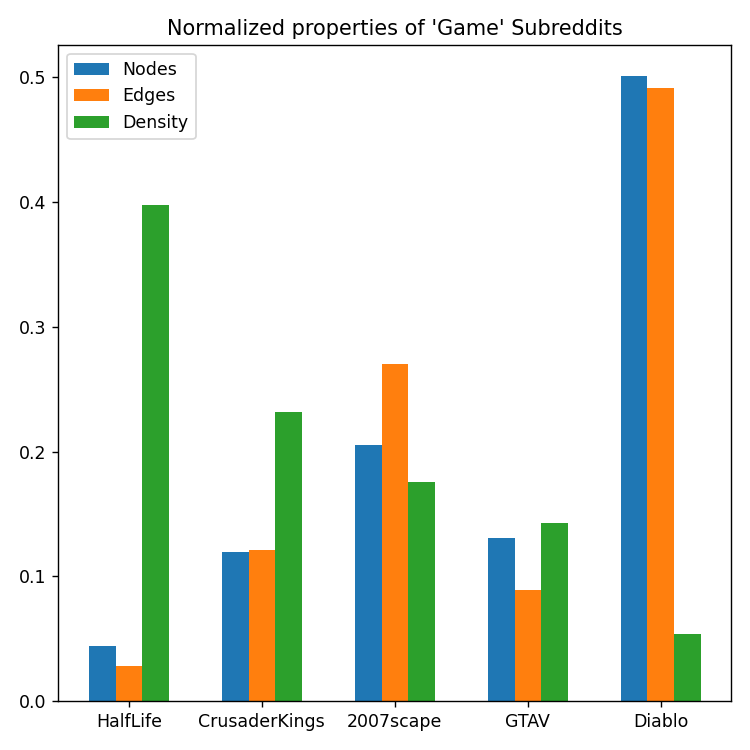

In [56]:
fig, ax = plt.subplots(figsize=(6,6))

In [59]:
plt.cla()

x = np.arange(len(normalized_params.index))
width = 0.2

bars_node = ax.bar(x=x-width, height=normalized_params['nodes'], width=width, label='Nodes')
bars_edge = ax.bar(x=x, height=normalized_params['edges'], width=width, label='Edges')
bars_density = ax.bar(x=x+width, height=normalized_params['density'], width=width, label='Density')

ax.set_title('Normalized properties of \'Game\' Subreddits')
ax.set_xticks(x, normalized_params.index)
ax.legend()

fig.tight_layout()

In [104]:
# For later analyses
strongest_comps = u.get_strongly_conn_comps(nets, True)

In [105]:
strongest_counts = u.count_strongest_comp(strongest_comps, params_game['nodes'])
strongest_counts

,nodes_largest_strong_comp,pct_nodes_largest_strong_comp
CrusaderKings,5086,0.657276
Diablo,20941,0.645928
GTAV,5928,0.699882
2007scape,8614,0.648400
HalfLife,2204,0.774965


# TODO:
The counting of strong components or the nodes in strong components is wrong!
SEE BELOW: strong_components = nodes_largest_strong_comp, which is WRONG

In [106]:
params_game['strong_components'] = {n: nx.number_strongly_connected_components(g) for n,g in nets.items()}.values()
params_game = pd.concat([params_game, strongest_counts], axis=1)
params_game.sort_values(by=['pct_nodes_largest_strong_comp'], axis=0, ascending=False)

,nodes,edges,density,strong_components,nodes_largest_strong_comp,pct_nodes_largest_strong_comp
HalfLife,2844,6115,0.000756,2204,2204,0.774965
GTAV,8470,19440,0.000271,5928,5928,0.699882
CrusaderKings,7738,26367,0.000440,5086,5086,0.657276
2007scape,13285,58847,0.000333,8614,8614,0.648400
Diablo,32420,107055,0.000102,20941,20941,0.645928


## Centrality:

## Reciprocity:

## Random Graphs: